In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [34]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 15))

In [35]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 22

In [36]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [37]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [38]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [39]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [40]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

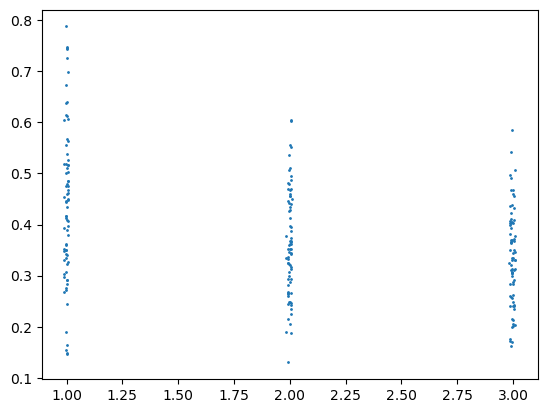

In [41]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [42]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [43]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(224, 3)


In [44]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [45]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [46]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.68it/s]


Loss: 622.0682032816112
Average Loss: 0.08512153848954723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.97it/s]


Loss: 427.16784582939
Average Loss: 0.058452086183550904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.32it/s]


Loss: 425.0188883780502
Average Loss: 0.058158030703072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.15it/s]


Loss: 424.3155284714885
Average Loss: 0.05806178550512979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.21it/s]


Loss: 422.9481907845475
Average Loss: 0.057874684015400586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.55it/s]


Loss: 421.82880904804915
Average Loss: 0.05772151191133677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.40it/s]


Loss: 421.5408802521415
Average Loss: 0.057682112787649356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.89it/s]


Loss: 421.501998398453
Average Loss: 0.05767679233695307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.66it/s]


Loss: 419.9364363765344
Average Loss: 0.05746256655398665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.20it/s]


Loss: 421.40510546881706
Average Loss: 0.057663533862728114
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▋                                                                                                                                                           | 126/7308 [00:03<00:58, 123.42it/s]

X_batch: 
torch.Size([128, 224])
tensor([[0.5695, 0.2749, 0.3117,  ..., 0.6178, 0.4569, 0.2820],
        [1.2025, 0.7638, 0.6651,  ..., 0.9485, 0.6041, 1.0331],
        [0.3933, 0.2209, 0.3021,  ..., 0.5089, 0.3768, 0.1961],
        ...,
        [0.5235, 0.2601, 0.1106,  ..., 0.5314, 0.2896, 0.1627],
        [0.0876, 0.0426, 0.0297,  ..., 0.1144, 0.0344, 0.0336],
        [0.4491, 0.3173, 0.1553,  ..., 0.5197, 0.2135, 0.1841]])
X_pred: 
torch.Size([128, 224])
tensor([[0.5105, 0.3267, 0.2240,  ..., 0.4935, 0.3367, 0.2398],
        [0.8918, 0.7905, 0.8344,  ..., 0.8479, 0.8178, 0.6916],
        [0.4459, 0.2706, 0.2079,  ..., 0.4277, 0.2782, 0.1970],
        ...,
        [0.5154, 0.2748, 0.1522,  ..., 0.5102, 0.2761, 0.1510],
        [0.1040, 0.0395, 0.0299,  ..., 0.1003, 0.0412, 0.0310],
        [0.4924, 0.2708, 0.1707,  ..., 0.4820, 0.2733, 0.1647]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.35it/s]


Loss: 420.5362853137776
Average Loss: 0.057544647689351074
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.67it/s]


Loss: 419.87236170540564
Average Loss: 0.057453798810263496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.99it/s]


Loss: 420.0762921832502
Average Loss: 0.05748170391122745
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.82it/s]


Loss: 418.8813729612157
Average Loss: 0.05731819553382809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.36it/s]


Loss: 419.15846189297736
Average Loss: 0.05735611137013921
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.62it/s]


Loss: 418.93074882775545
Average Loss: 0.057324951946874037
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.95it/s]


Loss: 418.9987189103849
Average Loss: 0.057334252724464276
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.01it/s]


Loss: 419.0984062352218
Average Loss: 0.057347893573511464
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.03it/s]


Loss: 418.5547053653281
Average Loss: 0.057273495534390824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.87it/s]


Loss: 418.4964752313681
Average Loss: 0.05726552753576465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.14it/s]


Loss: 418.470342827728
Average Loss: 0.05726195167319759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.43it/s]


Loss: 417.59746956825256
Average Loss: 0.057142510887828755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.50it/s]


Loss: 417.7529185221065
Average Loss: 0.05716378195431123
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.85it/s]


Loss: 417.63134108879603
Average Loss: 0.0571471457428566
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.52it/s]


Loss: 417.4427484849002
Average Loss: 0.05712133942048443
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.96it/s]


Loss: 417.5952582464088
Average Loss: 0.05714220829863284
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.63it/s]


Loss: 417.4215435979422
Average Loss: 0.05711843782128383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.50it/s]


Loss: 417.1221586051397
Average Loss: 0.05707747107350023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.08it/s]


Loss: 417.2524399913382
Average Loss: 0.05709529830204409
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.01it/s]


Loss: 416.77004211838357
Average Loss: 0.05702928874088445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.82it/s]


Loss: 417.2193693900481
Average Loss: 0.0570907730418785
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.74it/s]


Loss: 416.79001191374846
Average Loss: 0.057032021334667275
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.61it/s]


Loss: 416.14198495959863
Average Loss: 0.05694334769562105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.38it/s]


Loss: 415.6921711869072
Average Loss: 0.05688179682360526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.26it/s]


Loss: 414.9614712658804
Average Loss: 0.05678181051804603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.67it/s]


Loss: 414.43449426209554
Average Loss: 0.0567097009116168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.88it/s]


Loss: 413.4007585695945
Average Loss: 0.05656824829906876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.65it/s]


Loss: 413.35279332567006
Average Loss: 0.056561684910463886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.62it/s]


Loss: 412.64632618799806
Average Loss: 0.0564650145303774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.61it/s]


Loss: 412.37774029234424
Average Loss: 0.056428262218437907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.41it/s]


Loss: 412.54196221521124
Average Loss: 0.05645073374592382
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.96it/s]


Loss: 412.13122795079835
Average Loss: 0.05639453037093573
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.27it/s]


Loss: 411.54775615013205
Average Loss: 0.056314690223061306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.74it/s]


Loss: 411.47660262556747
Average Loss: 0.05630495383491618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.68it/s]


Loss: 411.14586104173213
Average Loss: 0.056259696365863726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 158.97it/s]


Loss: 410.3884743801318
Average Loss: 0.05615605834429828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.21it/s]


Loss: 410.2041957010515
Average Loss: 0.056130842323625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.71it/s]


Loss: 410.26183163165115
Average Loss: 0.056138729013635896
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.31it/s]


Loss: 409.40601155301556
Average Loss: 0.05602162172318221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.77it/s]


Loss: 409.39006024226546
Average Loss: 0.056019439004141414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.12it/s]


Loss: 409.22002322459593
Average Loss: 0.05599617176034427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.98it/s]


Loss: 408.8105704712216
Average Loss: 0.055940143742641155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.13it/s]


Loss: 408.83839607448317
Average Loss: 0.05594395129645364
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.57it/s]


Loss: 408.55932785058394
Average Loss: 0.055905764621043234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.72it/s]


Loss: 408.02436312218197
Average Loss: 0.05583256200358264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.53it/s]


Loss: 407.9628809031565
Average Loss: 0.05582414900152661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.55it/s]


Loss: 407.8562274395954
Average Loss: 0.055809554931526464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.28it/s]


Loss: 407.78692798130214
Average Loss: 0.055800072247030943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.25it/s]


Loss: 407.46337322029285
Average Loss: 0.05575579819653706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.55it/s]


Loss: 407.6162476474419
Average Loss: 0.0557767169741984
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.13it/s]


Loss: 407.1621852850076
Average Loss: 0.05571458474069617
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.05it/s]


Loss: 407.01268669660203
Average Loss: 0.055694127900465525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.84it/s]


Loss: 407.09448057832196
Average Loss: 0.0557053202761798
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.67it/s]


Loss: 406.6628446842078
Average Loss: 0.05564625679860534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.63it/s]


Loss: 406.5552270608023
Average Loss: 0.055631530796497304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.76it/s]


Loss: 406.41731329471804
Average Loss: 0.0556126591809959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.44it/s]


Loss: 406.5091069138143
Average Loss: 0.05562521988421105
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.34it/s]


Loss: 405.9747614231892
Average Loss: 0.05555210200098374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.92it/s]


Loss: 406.0468211788684
Average Loss: 0.055561962394481176
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.10it/s]


Loss: 406.07245404995047
Average Loss: 0.05556546990283942
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.04it/s]


Loss: 405.90434958040714
Average Loss: 0.055542467101861955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.87it/s]


Loss: 405.8595085516572
Average Loss: 0.05553633121943859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.23it/s]


Loss: 405.734971271595
Average Loss: 0.055519289993376436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.72it/s]


Loss: 405.48929182160646
Average Loss: 0.0554856721157097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.37it/s]


Loss: 405.63467779406346
Average Loss: 0.05550556620061076
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.44it/s]


Loss: 405.606541775167
Average Loss: 0.05550171617065777
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.97it/s]


Loss: 405.30986580764875
Average Loss: 0.05546112011598916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.86it/s]


Loss: 405.4611853000242
Average Loss: 0.05548182612206133
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.51it/s]


Loss: 405.31266887579113
Average Loss: 0.05546150367758499
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.46it/s]


Loss: 405.27205717749894
Average Loss: 0.05545594652127791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.43it/s]


Loss: 405.30984557280317
Average Loss: 0.05546111734712687
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.05it/s]


Loss: 404.98817572626285
Average Loss: 0.05541710122143717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.23it/s]


Loss: 405.10417508590035
Average Loss: 0.05543297414968532
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.49it/s]


Loss: 405.250399495475
Average Loss: 0.05545298296325602
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.08it/s]


Loss: 405.0298442400526
Average Loss: 0.055422802988512945
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.36it/s]


Loss: 405.2688408822287
Average Loss: 0.05545550641519276
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.99it/s]


Loss: 404.7131798027549
Average Loss: 0.05537947178472289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.67it/s]


Loss: 404.7856577974744
Average Loss: 0.0553893894085214
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.66it/s]


Loss: 404.80446269595996
Average Loss: 0.055391962602074435
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.32it/s]


Loss: 404.8274661535397
Average Loss: 0.05539511031110286
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.75it/s]


Loss: 404.7896369295195
Average Loss: 0.05538993389840168
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.21it/s]


Loss: 404.5249034850858
Average Loss: 0.05535370874180156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.58it/s]


Loss: 404.7028820370324
Average Loss: 0.05537806267611281
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.67it/s]


Loss: 404.4975649432745
Average Loss: 0.05534996783569711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.43it/s]


Loss: 404.49080024892464
Average Loss: 0.055349042179655805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.22it/s]


Loss: 404.18839894863777
Average Loss: 0.05530766269138448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.07it/s]


Loss: 404.53417573357
Average Loss: 0.055354977522382325
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.63it/s]


Loss: 404.645120580215
Average Loss: 0.05537015880955323
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.75it/s]


Loss: 404.1531707663089
Average Loss: 0.05530284219571824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.24it/s]


Loss: 404.1968748450745
Average Loss: 0.05530882250206274
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.53it/s]


Loss: 404.48800455383025
Average Loss: 0.0553486596269609
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.88it/s]


Loss: 404.49573228298686
Average Loss: 0.055349717061164046
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.63it/s]


Loss: 404.2633799267933
Average Loss: 0.05531792281428479
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.36it/s]


Loss: 404.1323086854536
Average Loss: 0.05529998750485134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.31it/s]


Loss: 404.2255422300659
Average Loss: 0.055312745242209346
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.21it/s]


Loss: 404.0199383716099
Average Loss: 0.05528461116196085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.59it/s]


Loss: 404.04128223704174
Average Loss: 0.05528753177846767
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.44it/s]


Loss: 403.8934362519067
Average Loss: 0.0552673010744262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.19it/s]


Loss: 404.2587650474161
Average Loss: 0.05531729133106405
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.71it/s]


Loss: 404.1216900974978
Average Loss: 0.05529853449609986
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.23it/s]


Loss: 403.9324899625499
Average Loss: 0.055272645041399816
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.78it/s]


Loss: 403.8811130542308
Average Loss: 0.05526561481311314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.44it/s]


Loss: 404.11533780861646
Average Loss: 0.05529766527211501
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.63it/s]


Loss: 404.03337883320637
Average Loss: 0.055286450305583795
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.02it/s]


Loss: 404.02214174252003
Average Loss: 0.05528491266318008
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.74it/s]


Loss: 404.1164045468904
Average Loss: 0.05529781124068013
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.62it/s]


Loss: 403.91901311208494
Average Loss: 0.05527080091845716
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.82it/s]


Loss: 403.87014812394045
Average Loss: 0.05526411441214292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.12it/s]


Loss: 403.8581338424701
Average Loss: 0.05526247042179394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.82it/s]


Loss: 403.776088808896
Average Loss: 0.05525124367937822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.75it/s]


Loss: 403.7678532854188
Average Loss: 0.05525011676045687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.13it/s]


Loss: 403.8604098397773
Average Loss: 0.0552627818609438
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.83it/s]


Loss: 403.6764078568667
Average Loss: 0.05523760370236271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.24it/s]


Loss: 403.6331883966923
Average Loss: 0.055231689709454336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.98it/s]


Loss: 403.62008886947297
Average Loss: 0.05522989721804501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.86it/s]


Loss: 403.93872433295473
Average Loss: 0.055273498129851495
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.26it/s]


Loss: 403.8001870168373
Average Loss: 0.055254541190043416
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.79it/s]


Loss: 403.41953392885625
Average Loss: 0.05520245401325346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.23it/s]


Loss: 403.52230764064007
Average Loss: 0.05521651719220581
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.54it/s]


Loss: 403.46864680806175
Average Loss: 0.05520917444007413
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.04it/s]


Loss: 403.48584789107554
Average Loss: 0.055211528173381985
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.50it/s]


Loss: 403.79954558610916
Average Loss: 0.055254453419007823
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.02it/s]


Loss: 403.45727086882107
Average Loss: 0.05520761779814191
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.58it/s]


Loss: 403.509480237728
Average Loss: 0.05521476193729173
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.62it/s]


Loss: 403.754678710131
Average Loss: 0.055248313999744246
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.36it/s]


Loss: 403.41495769727044
Average Loss: 0.05520182781845518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.04it/s]


Loss: 403.5218640831299
Average Loss: 0.05521645649741789
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.75it/s]


Loss: 403.3304373091087
Average Loss: 0.055190262357568236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.77it/s]


Loss: 403.437069094507
Average Loss: 0.055204853461207855
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.01it/s]


Loss: 403.5322158096824
Average Loss: 0.05521787298983065
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.71it/s]


Loss: 403.4246291301679
Average Loss: 0.05520315122197152
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.67it/s]


Loss: 403.36611094651744
Average Loss: 0.055195143807678905
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.28it/s]


Loss: 403.41905707493424
Average Loss: 0.05520238876230627
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.37it/s]


Loss: 403.1813068583142
Average Loss: 0.05516985589194228
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.40it/s]


Loss: 403.184336777078
Average Loss: 0.05517027049494773
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.51it/s]


Loss: 403.51986807817593
Average Loss: 0.05521618337139791
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.09it/s]


Loss: 403.4273280540947
Average Loss: 0.05520352053285368
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.82it/s]


Loss: 403.2675931665581
Average Loss: 0.05518166299487658
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.63it/s]


Loss: 403.42512888787314
Average Loss: 0.055203219606988665
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.50it/s]


Loss: 403.32942755846307
Average Loss: 0.05519012418698181
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.64it/s]


Loss: 403.2868883223273
Average Loss: 0.0551843032734438
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.22it/s]


Loss: 403.3620351839345
Average Loss: 0.055194586095229134
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.65it/s]


Loss: 403.39299845625646
Average Loss: 0.05519882299620368
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.95it/s]

Loss: 403.6348890874069
Average Loss: 0.055231922425753546
Done, best loss: 403.1813068583142
Done


<All keys matched successfully>

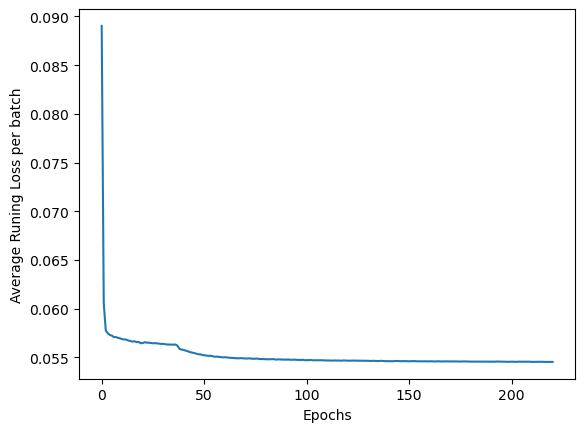

In [32]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [33]:
torch.save(final_model, 'model_100206_15g_04.pt')